# Load Data

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', 500)

In [2]:
train_filepath = '../data/raw/train_v2.csv'
test_filepath = '../data/raw/test_v2.csv'

In [5]:
def load_df(csv_path='../data/raw/train.csv_v2', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    # JSON_COLUMNS = ['customDimensions']
    # conv2 = lambda x: json.loads((x).replace("'",'"'))
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)

    for column in JSON_COLUMNS:
        # temp = pd.DataFrame(df[column].tolist(), columns=[column])
        temp = df[column]
        column_as_df = json_normalize(temp)
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [6]:
%%time
df_train = load_df(csv_path=train_filepath, nrows=20000)

Loaded train_v2.csv. Shape: (20000, 59)
Wall time: 22.9 s


In [40]:
#%%time
#df_test = load_df(csv_path=test_filepath, nrows=20000)

In [120]:
# df_train = pd.read_csv(train_filepath, nrows=20000)
# df_train = pd.read_csv(test_filepath)

# Describe data

In [7]:
df_train.shape

(20000, 59)

In [9]:
df_train.head().T

,0,1,2,3,4
channelGrouping,Organic Search,Referral,Direct,Organic Search,Organic Search
customDimensions,"[{'index': '4', 'value': 'EMEA'}]","[{'index': '4', 'value': 'North America'}]","[{'index': '4', 'value': 'North America'}]","[{'index': '4', 'value': 'EMEA'}]","[{'index': '4', 'value': 'Central America'}]"
date,20171016,20171016,20171016,20171016,20171016
fullVisitorId,3162355547410993243,8934116514970143966,7992466427990357681,9075655783635761930,6960673291025684308
hits,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...","[{'hitNumber': '1', 'time': '0', 'hour': '14',..."
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1508198450,1508176307,1508201613,1508169851,1508190552
visitNumber,1,6,1,1,1
visitStartTime,1508198450,1508176307,1508201613,1508169851,1508190552
device.browser,Firefox,Chrome,Chrome,Chrome,Chrome


In [10]:
df_train.dtypes

channelGrouping                                      object
customDimensions                                     object
date                                                  int64
fullVisitorId                                        object
hits                                                 object
socialEngagementType                                 object
visitId                                               int64
visitNumber                                           int64
visitStartTime                                        int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                        bool
device.language                                      object
device.mobileDeviceBranding             

# Data cleaning

In [11]:
# Convert total columns to float
bool_cols = ['trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect', 'device.isMobile']
columns_types = {}
for col in df_train.columns:
    if 'total' in col:
        columns_types[col] = float
    elif col in bool_cols:
        columns_types[col] = float
        
df_train = df_train.astype(columns_types)

In [12]:
# Convert visitStartTime to datetime, drop date column that has the same information
# df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d')
df_train['visitStartTime'] = pd.to_datetime(df_train['visitStartTime'], unit='s')
df_train.drop('date', axis=1, inplace=True)

In [13]:
# Create datetime features
df_train['visitStartTime_hour'] = df_train['visitStartTime'].dt.hour
df_train['visitStartTime_weekday'] = df_train['visitStartTime'].dt.weekday
df_train['visitStartTime_week'] = df_train['visitStartTime'].dt.week
df_train['visitStartTime_month'] = df_train['visitStartTime'].dt.month

In [14]:
# Get number of unique and nulls for each column, add to delete list if 1 unique and 0 nulls
columns_to_drop = []
for col in df_train.columns:
    print(col)
    _nunique = df_train[col].nunique()
    _nnulls = df_train[col].isnull().sum()
    print('Unique: ',_nunique)
    print('Nulls: ',_nnulls)
    if (_nunique == 1) & (_nnulls == 0):
        columns_to_drop.append(col)
        print('Added to columns to drop')
    print('-' * 30)

channelGrouping
Unique:  7
Nulls:  0
------------------------------
customDimensions
Unique:  6
Nulls:  0
------------------------------
fullVisitorId
Unique:  18384
Nulls:  0
------------------------------
hits
Unique:  19554
Nulls:  0
------------------------------
socialEngagementType
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
visitId
Unique:  19667
Nulls:  0
------------------------------
visitNumber
Unique:  99
Nulls:  0
------------------------------
visitStartTime
Unique:  19666
Nulls:  0
------------------------------
device.browser
Unique:  25
Nulls:  0
------------------------------
device.browserSize
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device.browserVersion
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device.deviceCategory
Unique:  3
Nulls:  0
------------------------------
device.flashVersion
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------


In [15]:
# Drop columns from columns_to_drop list
df_train.drop(columns_to_drop, axis=1, inplace=True)

In [16]:
# Show unique values of columns with null values
null_columns = df_train.columns[df_train.isnull().sum() > 0]
for col in null_columns:
    print(col)
    print(df_train[col].nunique(), 'unique values')
    print(df_train[col].unique()[:5])
    print('-' * 30)

totals.bounces
1 unique values
[ 1. nan]
------------------------------
totals.newVisits
1 unique values
[ 1. nan]
------------------------------
totals.pageviews
80 unique values
[1. 2. 3. 4. 5.]
------------------------------
totals.sessionQualityDim
93 unique values
[1. 2. 3. 4. 6.]
------------------------------
totals.timeOnSite
1413 unique values
[nan 28. 38.  1. 52.]
------------------------------
totals.totalTransactionRevenue
186 unique values
[      nan 17190000. 13000000. 65300000. 25230000.]
------------------------------
totals.transactionRevenue
168 unique values
[      nan 15190000.  8000000. 57300000. 18230000.]
------------------------------
totals.transactions
3 unique values
[nan  1.  2.  3.]
------------------------------
trafficSource.adContent
34 unique values
[nan 'Placement Accessories 300 x 250' 'Google Merchandise Store'
 'Bags 300x250' 'Display Ad created 3/11/14']
------------------------------
trafficSource.adwordsClickInfo.adNetworkType
2 unique values
[na

In [17]:
# Fill numeric columns with zero
object_cols = []
for col in df_train.columns:
    if col == 'trafficSource.adwordsClickInfo.isVideoAd':
        df_train[col] = df_train[col].fillna(1)
    elif col in df_train._get_numeric_data().columns:
        print(col, ': Numeric')
        df_train[col] = df_train[col].fillna(0)
    else:
        print(col, ': Object')
        object_cols.append(col)
        df_train[col] = df_train[col].fillna('unknown')

channelGrouping : Object
customDimensions : Object
fullVisitorId : Object
hits : Object
visitId : Numeric
visitNumber : Numeric
visitStartTime : Object
device.browser : Object
device.deviceCategory : Object
device.isMobile : Numeric
device.operatingSystem : Object
geoNetwork.city : Object
geoNetwork.continent : Object
geoNetwork.country : Object
geoNetwork.metro : Object
geoNetwork.networkDomain : Object
geoNetwork.region : Object
geoNetwork.subContinent : Object
totals.bounces : Numeric
totals.hits : Numeric
totals.newVisits : Numeric
totals.pageviews : Numeric
totals.sessionQualityDim : Numeric
totals.timeOnSite : Numeric
totals.totalTransactionRevenue : Numeric
totals.transactionRevenue : Numeric
totals.transactions : Numeric
trafficSource.adContent : Object
trafficSource.adwordsClickInfo.adNetworkType : Object
trafficSource.adwordsClickInfo.gclId : Object
trafficSource.adwordsClickInfo.page : Object
trafficSource.adwordsClickInfo.slot : Object
trafficSource.campaign : Object
traffi

In [18]:
# Convert categorical values to numerical
df_train[object_cols].nunique()

channelGrouping                                     7
customDimensions                                    6
fullVisitorId                                   18384
hits                                            19554
visitStartTime                                  19666
device.browser                                     25
device.deviceCategory                               3
device.operatingSystem                             16
geoNetwork.city                                   162
geoNetwork.continent                                6
geoNetwork.country                                155
geoNetwork.metro                                   32
geoNetwork.networkDomain                         2516
geoNetwork.region                                 125
geoNetwork.subContinent                            22
trafficSource.adContent                            35
trafficSource.adwordsClickInfo.adNetworkType        3
trafficSource.adwordsClickInfo.gclId              596
trafficSource.adwordsClickIn

In [30]:
# df_train.groupby('fullVisitorId').sum()['totals.transactionRevenue'].sort_values()
df_train[df_train['fullVisitorId']=='1814166460229302850']

,channelGrouping,customDimensions,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitStartTime_hour,visitStartTime_weekday,visitStartTime_week,visitStartTime_month,has_revenue
15505,Direct,"[{'index': '4', 'value': 'North America'}]",1814166460229302850,"[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",1486135601,8,2017-02-03 15:26:41,Chrome,desktop,0.0,Chrome OS,not available in demo dataset,Americas,United States,not available in demo dataset,embarqhsd.net,not available in demo dataset,Northern America,0.0,54.0,0.0,40.0,0.0,935.0,1.180470e+09,1.171470e+09,1.0,unknown,unknown,unknown,1.0,unknown,unknown,(not set),1.0,unknown,(none),unknown,(direct),15,4,5,2,True


In [20]:
# Check low occurencies unique values
high_dimension_cols = ['geoNetwork.city', 'geoNetwork.country', 'geoNetwork.networkDomain', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.source']
for col in high_dimension_cols:
    # print((df_train[col].value_counts()>20).sum(), col)
    # df_train.loc[df_train[col].value_counts()[df_train[col]].values < 20, col] = 'Other'
    print((df_train[col].value_counts()))

not available in demo dataset    11342
Mountain View                      942
(not set)                          749
New York                           584
San Francisco                      455
Sunnyvale                          305
London                             278
Los Angeles                        248
San Jose                           213
Chicago                            155
Seattle                            133
Toronto                            131
Bangkok                            115
Istanbul                           115
Bengaluru                          107
Paris                              107
Dublin                             102
Santa Clara                         98
Sydney                              96
Minato                              93
Warsaw                              88
Chennai                             82
Sao Paulo                           79
Hong Kong                           79
Madrid                              75
Mumbai                   

# Prepare data to fit model
- Split train and validation (by visitor id)
- get x and y (based on date)
- aggregate x and y
- dummy x and y if necessary
- fit model
- evaluate

In [41]:
# Split train and validation
validation_size = 0.1
validation_cut = int(df_train['fullVisitorId'].nunique()*validation_size)
validation_index = np.random.choice(validation_cut, size=validation_cut, replace=False)
validation_ids = df_train['fullVisitorId'].unique()[validation_index]
validation_filter = df_train['fullVisitorId'].apply(lambda x: x  in validation_ids)
train = df_train[~validation_filter]
validation = df_train[validation_filter]

In [48]:
# get x and y for train and validation
print(train.visitStartTime.min())
print(train.visitStartTime.max())

train_x_filter = train['visitStartTime'] < '2018-01-16'
train_x = train[train_x_filter]
train_y = train[~train_x_filter]

validation_x_filter = validation['visitStartTime'] < '2018-01-16'
validation_x = validation[validation_x_filter]
validation_y = validation[~validation_x_filter]

2016-09-02 07:00:01
2018-04-16 06:58:39


# Data Exploration

In [21]:
import seaborn as sns
# import matplotlib
import matplotlib.pyplot as plt

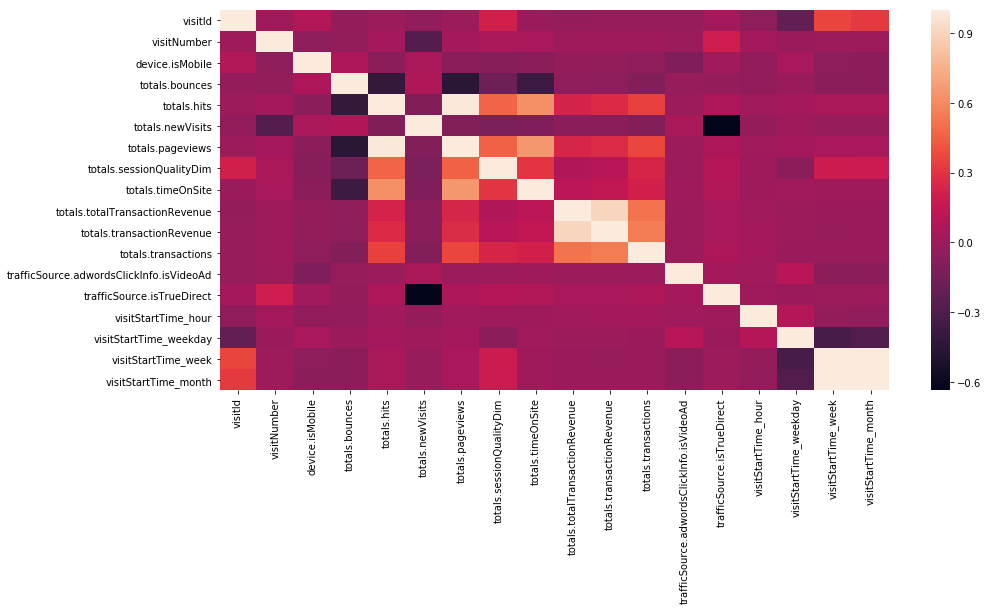

In [22]:
# Numeric correlations
plt.figure(figsize = (15,7))
sns.heatmap(df_train.corr())
plt.show()

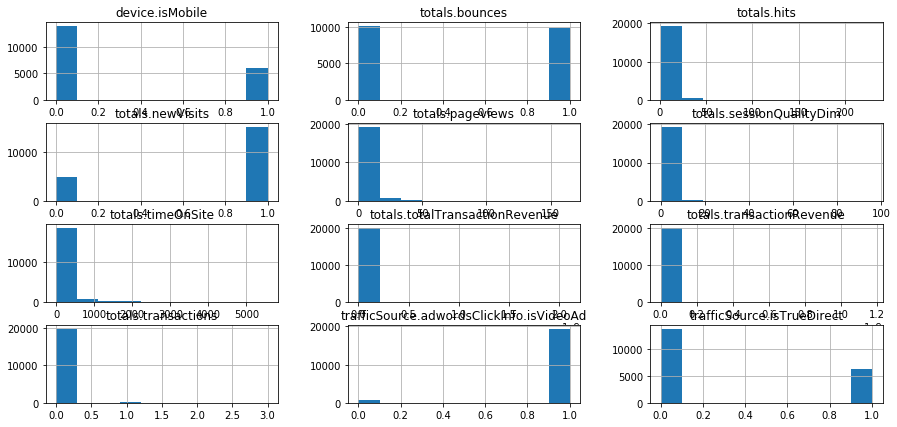

In [23]:
# Histograms
# plt.figure(figsize = (15,7))
df_train.select_dtypes(include=[float, int]).hist(figsize = (15,7))
plt.show()

In [24]:
# % of session with revenue
'{}% of total sessions has revenue'.format(((df_train['totals.transactionRevenue']>0).sum()/len(df_train))*100)

'0.9650000000000001% of total sessions has revenue'

In [25]:
df_train['has_revenue'] = df_train['totals.transactionRevenue'] > 0

In [26]:
target_col = 'has_revenue'
N=20
i = 0
text = ''
for col in df_train.columns:
    if df_train[col].nunique() < N:
        i+=1
        text += '{}. Column: {}\n'.format(i,col)
        text += '\nNormalized by column:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col],normalize="columns"))
        text += '\nNormalized by index:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col],normalize="index"))
        text += '\nActuals:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col]))
        text += '\n\n'
print(text)

1. Column: channelGrouping

Normalized by column:
has_revenue         False     True 
channelGrouping                    
Affiliates       0.021457  0.000000
Direct           0.152572  0.129534
Display          0.018175  0.010363
Organic Search   0.478215  0.326425
Paid Search      0.026253  0.036269
Referral         0.128894  0.497409
Social           0.174433  0.000000
Normalized by index:
has_revenue         False     True 
channelGrouping                    
Affiliates       1.000000  0.000000
Direct           0.991795  0.008205
Display          0.994475  0.005525
Organic Search   0.993393  0.006607
Paid Search      0.986717  0.013283
Referral         0.963760  0.036240
Social           1.000000  0.000000
Actuals:
has_revenue      False  True 
channelGrouping              
Affiliates         425      0
Direct            3022     25
Display            360      2
Organic Search    9472     63
Paid Search        520      7
Referral          2553     96
Social            3455      0

2

ValueError: num must be 1 <= num <= 9, not 10

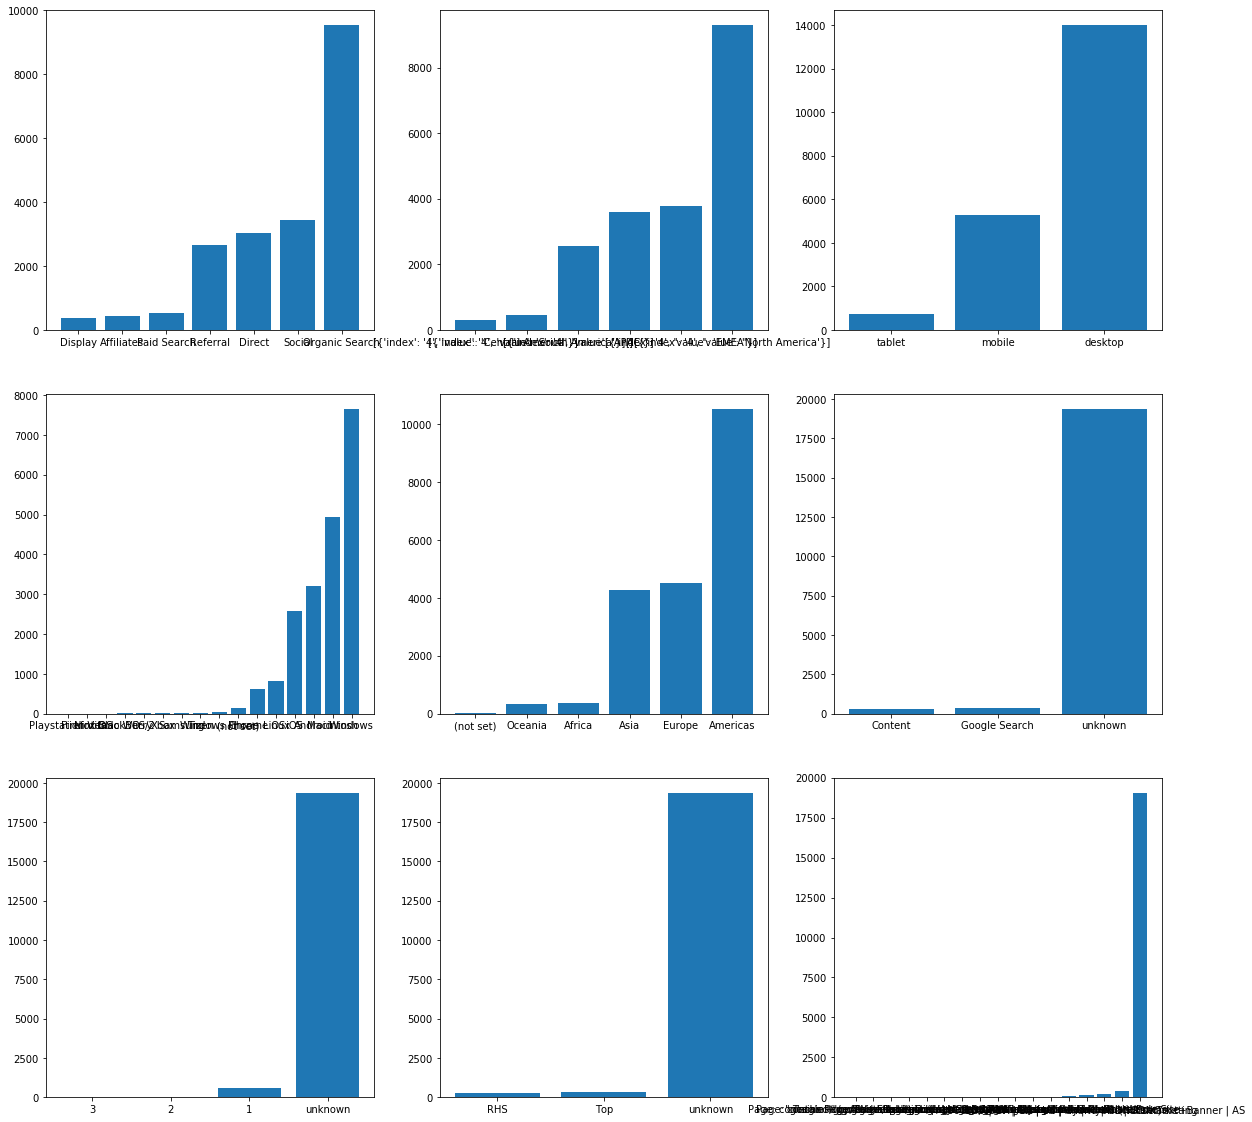

In [27]:
i = 0
fig = plt.figure(figsize=(20, 20))
for col in df_train.columns:
    if (df_train[col].dtype=='object') & (df_train[col].nunique() < 20):
        i += 1
        height = df_train.groupby(col)[col].count().sort_values()
        ax = plt.subplot(3, 3, i)
        plt.bar(height.index, height)

<pre>
Next steps:
- Convert categoricals to numerial
- Convert numerical to bins
- Split train/test
- Predict revenue
- Predict future revenue